<Body>   
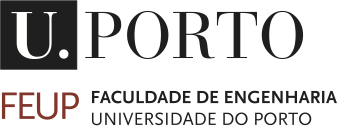   
<h1> <b>Advanced Topics on Machine Learning </b> </h1>
<p><b>Cátia Teixeira</b> (200808037) | <b>Henrique Bastos</b> (202204383) | <b>Ian Karkles</b> (202200596) | <b>Vitor Pereira</b> (202210497)
<p>Master in Data Science and Engineering</p>
</Body>
Faculdade de Engenharia da Universidade do Porto

---

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
from torchsummary import summary
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, average_precision_score
from imblearn.metrics import classification_report_imbalanced
from pycaret.classification import *


# Data preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/creditcard.csv')
#df = pd.read_csv('/Users/henriqueribeiro/Downloads/creditcard.csv')

#split df into train and test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
#print the characteristics of the dataframes
print('Train shape: ', df_train.shape)
print('Test shape: ', df_test.shape)

Train shape:  (227845, 31)
Test shape:  (56962, 31)


# Fraud Dataset Creation

In [4]:
class FraudDataset(Dataset):

  def __init__(self, dataframe, fraud = True):
    df = dataframe
    if fraud:
      df = df[df['Class'] == 1]

    x = df.iloc[:, 0:-1].values
    y = df.iloc[:, -1].values
    self.x_data=torch.tensor(x,dtype=torch.float32)
    self.y_data=torch.tensor(y,dtype=torch.float32)

    self.features = x.shape[1]
  def __len__(self):
    return len(self.x_data)

  def __getitem__(self,idx):
    return self.x_data[idx], self.y_data[idx]

creditData = FraudDataset(df_train, fraud= True)
creditDataTest = FraudDataset(df_test, fraud= True)

In [5]:
train_dataloader = DataLoader(creditData, batch_size=32, drop_last=True)
test_dataloader = DataLoader(creditDataTest, batch_size=32, drop_last=True)

## Unconditional Vanilla GAN - Data Augmentation

### Architecture

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(latent_dim, 1024),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(16, nr_features),
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [7]:
class Discriminator(nn.Module):
    def __init__(self, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(nr_features, 256),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(16, 1),

        )
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return torch.sigmoid(x)

In [8]:
class GAN:
    def __init__(self, train_df, latent_size=128):
        self.lr = 0.00005
        self.batch_size = 16
        self.n_critic = 1
        self.clip_value = 0.0001
        self.cur_batch_size = 64
        self.latent_dim = 128
        self.criterion = nn.BCELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.dataset = FraudDataset(train_df, fraud= True)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)

        self.G = Generator(latent_dim=latent_size, nr_features=self.dataset.features).to(self.device)
        self.D = Discriminator(nr_features=self.dataset.features).to(self.device)
        self.latent_size = latent_size

        self.g_optimizer = torch.optim.Adam(self.G.parameters(), self.lr)
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), self.lr)





    def train_generator(self,real_data):
        # Clear generator gradients
        self.g_optimizer.zero_grad()

        fake_targets = torch.ones(real_data.size(0)).to(self.device)
        fake_targets = fake_targets - 0.1

        # Random noise from a uniform distribution
        latent_space_samples = torch.randn(real_data.size(0), self.latent_dim).to(self.device)
        generated_data = self.G(latent_space_samples)  # Fake data generated by the generator
        fake_preds = self.D(generated_data).reshape(-1)

        g_loss = self.criterion(fake_preds, fake_targets)
        g_loss.backward()
        self.g_optimizer.step()

        return g_loss, generated_data

    def train_discriminator(self, real_data, real_labels):
        self.d_optimizer.zero_grad()
        real_labels = torch.ones(real_data.size(0)).to(self.device) * 0.9

        real_preds = self.D(real_data).reshape(-1)
        d_loss_real = self.criterion(real_preds, real_labels)

        fake_labels = torch.zeros(self.cur_batch_size).to(self.device) * 0.1

        # random noise from uniform distribution
        latent_space_samples = torch.randn(self.cur_batch_size, self.latent_dim).to(self.device)


        generated_data = self.G(latent_space_samples).detach()
        fake_preds = self.D(generated_data).reshape(-1)
        d_loss_fake = self.criterion(fake_preds, fake_labels)


        loss = d_loss_real + d_loss_fake

        # Compute gradients
        loss.backward()
        # Adjust the parameters using backprop
        self.d_optimizer.step()


        return loss

    def train(self,real_data, epochs=1000):
        losses_gen = []
        losses_dis = []
        for epoch in range(0,epochs):
            for i, (real_data, real_labels)  in enumerate(self.dataloader):
                real_data, real_labels = real_data.to(self.device), real_labels.to(self.device)
                # Train discriminator
                d_error = self.train_discriminator(real_data, real_labels)
                # Train generator every n_critic iterations
                if i % self.n_critic == 0:
                    g_error, _ = self.train_generator(real_data)
                losses_gen.append(g_error)
                losses_dis.append(d_error)

            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f} \n'
                .format(epoch+1, epochs, i+1, len(self.dataloader), d_error.item(), g_error.item()))

        return losses_gen, losses_dis



    def sample(self, count):
        with torch.no_grad():
            z = torch.Tensor(np.random.normal(0, 1, (count, self.latent_size))).to(self.device)
            gen = self.G(z)
            return gen.cpu().numpy()

### Training the model

In [9]:
gan = GAN(df_train)

In [10]:
losses_gen, losses_dis = gan.train(df_train, epochs=1000)

Epoch [1/1000], Step [25/25], d_loss: 30.3641, g_loss: 0.6330 

Epoch [2/1000], Step [25/25], d_loss: 9.9368, g_loss: 0.6299 

Epoch [3/1000], Step [25/25], d_loss: 9.8590, g_loss: 0.6345 

Epoch [4/1000], Step [25/25], d_loss: 13.4957, g_loss: 0.6354 

Epoch [5/1000], Step [25/25], d_loss: 16.3572, g_loss: 0.6406 

Epoch [6/1000], Step [25/25], d_loss: 8.1848, g_loss: 0.6397 

Epoch [7/1000], Step [25/25], d_loss: 9.7967, g_loss: 0.6395 

Epoch [8/1000], Step [25/25], d_loss: 9.8936, g_loss: 0.6438 

Epoch [9/1000], Step [25/25], d_loss: 10.7599, g_loss: 0.6431 

Epoch [10/1000], Step [25/25], d_loss: 9.8395, g_loss: 0.6475 

Epoch [11/1000], Step [25/25], d_loss: 10.7544, g_loss: 0.6453 

Epoch [12/1000], Step [25/25], d_loss: 10.7511, g_loss: 0.6493 

Epoch [13/1000], Step [25/25], d_loss: 10.7485, g_loss: 0.6548 

Epoch [14/1000], Step [25/25], d_loss: 9.9064, g_loss: 0.6527 

Epoch [15/1000], Step [25/25], d_loss: 10.7436, g_loss: 0.6525 

Epoch [16/1000], Step [25/25], d_loss: 11

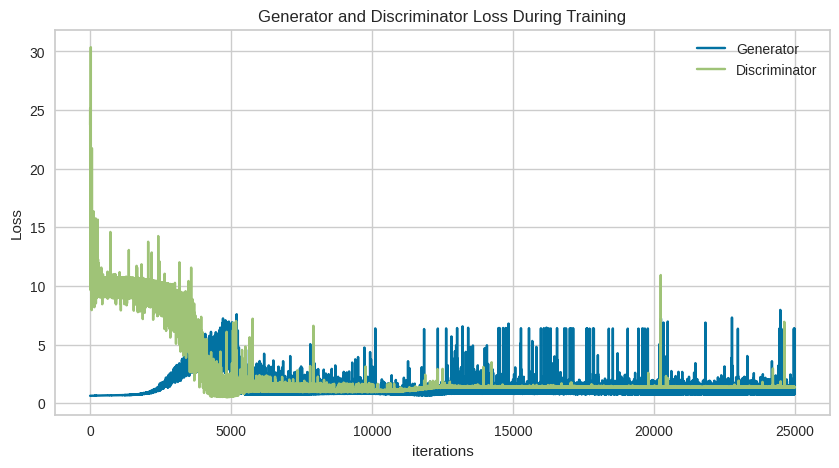

In [11]:
def plot_losses(losses_gen, losses_dis):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")

    #convert losses into numpy
    losses_gen = [i.cpu().detach().numpy() for i in losses_gen]
    losses_dis = [i.cpu().detach().numpy() for i in losses_dis]
    plt.plot(losses_gen,label="Generator")
    plt.plot(losses_dis,label="Discriminator")
    plt.xlabel("iterations") #Epochs * Steps
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_losses(losses_gen, losses_dis)

### Join augmented data + real data

In [12]:
#define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

sample_number = df_train[df_train['Class'] == 0].shape[0]
gan_samples = gan.sample(sample_number)
samples_test = np.append(gan_samples, np.ones((sample_number, 1)), axis=1)
gan_df = pd.DataFrame(samples_test, columns=df_train.columns)
#concat wgan_df with df_train
df_concat = pd.concat([df_train, gan_df], ignore_index=True)

cuda:0


In [13]:
df_concat['Class'].value_counts()

1.0    227845
0.0    227451
Name: Class, dtype: int64

# Model evaluation

### Deep Neural Network

In [14]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, average_precision_score
from imblearn.metrics import classification_report_imbalanced


def common_metrics(y_true, y_pred, y_prob):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true')
    RocCurveDisplay.from_predictions(y_true, y_prob)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    #
    fig, ax = plt.subplots()
    PrecisionRecallDisplay.from_predictions(y_true, y_prob, ax=ax)
    # P / (P + N)
    ap_frauds = (len(y_true[y_true == 1]) / len(y_true))
    plt.axhline(y=ap_frauds, color='r', linestyle='-')
    plt.show()
    #
    print(classification_report_imbalanced(y_true, y_pred))
    print("AUPRC:", auc(recall, precision))
    print("AP:", average_precision_score(y_true, y_prob))

In [15]:
class Model(nn.Module):
    def __init__(self, nr_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(nr_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return torch.flatten(self.model(x))

In [16]:
class FraudModel:
    def __init__(self, train_df):
        self.lr = 0.001
        self.batch_size = 64
        self.dataset = FraudDataset(train_df, fraud = False)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)
        self.model = Model(nr_features=self.dataset.features).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = nn.BCELoss()

    def train(self, epochs=100):
        for epoch in range(epochs):
            epoch_loss = 0
            for _, (x, y) in enumerate(tqdm(self.dataloader)):
                x,y = x.to(device), y.to(device)
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() / len(x)
            print("[Epoch %d/%d] loss: %f" % (epoch+1, epochs, np.mean(epoch_loss)))

    def predict(self, x):
        with torch.no_grad():
            pred = self.model(x)
            return pred.cpu().numpy()

    def evaluate(self, test_df, confidence=0.50):
            input = torch.Tensor(test_df.drop(['Class'], axis=1).values).to(device)
            y_true = torch.Tensor(test_df['Class'].values).to(device)
            #preds = self.predict(input)
            preds = np.array([])
            dataloader_test = DataLoader(TensorDataset(input, y_true), batch_size=64, shuffle=False)

            for (inp, _) in dataloader_test:
                pred = self.predict(inp)
                preds = np.concatenate((preds, pred), axis=None)
            labels = np.zeros_like(preds)
            labels[preds >= confidence] = 1
            common_metrics(y_true.cpu().numpy(), labels,preds)

100%|██████████| 7114/7114 [00:23<00:00, 305.32it/s]


[Epoch 1/300] loss: 3.433711


100%|██████████| 7114/7114 [00:24<00:00, 295.65it/s]


[Epoch 2/300] loss: 2.453993


100%|██████████| 7114/7114 [00:24<00:00, 286.98it/s]


[Epoch 3/300] loss: 2.009925


100%|██████████| 7114/7114 [00:23<00:00, 303.25it/s]


[Epoch 4/300] loss: 1.756800


100%|██████████| 7114/7114 [00:24<00:00, 294.53it/s]


[Epoch 5/300] loss: 1.585130


100%|██████████| 7114/7114 [00:24<00:00, 288.99it/s]


[Epoch 6/300] loss: 1.422332


100%|██████████| 7114/7114 [00:24<00:00, 294.89it/s]


[Epoch 7/300] loss: 1.322209


100%|██████████| 7114/7114 [00:25<00:00, 284.00it/s]


[Epoch 8/300] loss: 1.168135


100%|██████████| 7114/7114 [00:24<00:00, 289.54it/s]


[Epoch 9/300] loss: 1.070090


100%|██████████| 7114/7114 [00:24<00:00, 290.93it/s]


[Epoch 10/300] loss: 1.043962


100%|██████████| 7114/7114 [00:24<00:00, 294.31it/s]


[Epoch 11/300] loss: 1.035667


100%|██████████| 7114/7114 [00:24<00:00, 288.76it/s]


[Epoch 12/300] loss: 0.941248


100%|██████████| 7114/7114 [00:24<00:00, 291.14it/s]


[Epoch 13/300] loss: 0.922713


100%|██████████| 7114/7114 [00:23<00:00, 298.86it/s]


[Epoch 14/300] loss: 0.910070


100%|██████████| 7114/7114 [00:24<00:00, 288.38it/s]


[Epoch 15/300] loss: 0.884880


100%|██████████| 7114/7114 [00:24<00:00, 292.76it/s]


[Epoch 16/300] loss: 0.844800


100%|██████████| 7114/7114 [00:23<00:00, 305.77it/s]


[Epoch 17/300] loss: 0.839660


100%|██████████| 7114/7114 [00:24<00:00, 294.79it/s]


[Epoch 18/300] loss: 0.812536


100%|██████████| 7114/7114 [00:24<00:00, 295.69it/s]


[Epoch 19/300] loss: 0.808440


100%|██████████| 7114/7114 [00:23<00:00, 303.06it/s]


[Epoch 20/300] loss: 0.905358


100%|██████████| 7114/7114 [00:24<00:00, 293.63it/s]


[Epoch 21/300] loss: 0.760058


100%|██████████| 7114/7114 [00:24<00:00, 294.91it/s]


[Epoch 22/300] loss: 0.818964


100%|██████████| 7114/7114 [00:23<00:00, 303.90it/s]


[Epoch 23/300] loss: 0.765337


100%|██████████| 7114/7114 [00:24<00:00, 293.98it/s]


[Epoch 24/300] loss: 0.795320


100%|██████████| 7114/7114 [00:23<00:00, 298.01it/s]


[Epoch 25/300] loss: 0.700819


100%|██████████| 7114/7114 [00:23<00:00, 303.44it/s]


[Epoch 26/300] loss: 0.736886


100%|██████████| 7114/7114 [00:24<00:00, 294.66it/s]


[Epoch 27/300] loss: 0.720840


100%|██████████| 7114/7114 [00:23<00:00, 297.03it/s]


[Epoch 28/300] loss: 0.695691


100%|██████████| 7114/7114 [00:23<00:00, 304.21it/s]


[Epoch 29/300] loss: 0.752657


100%|██████████| 7114/7114 [00:24<00:00, 294.78it/s]


[Epoch 30/300] loss: 0.651350


100%|██████████| 7114/7114 [00:23<00:00, 300.37it/s]


[Epoch 31/300] loss: 0.655031


100%|██████████| 7114/7114 [00:23<00:00, 301.77it/s]


[Epoch 32/300] loss: 0.662246


100%|██████████| 7114/7114 [00:24<00:00, 292.64it/s]


[Epoch 33/300] loss: 0.604273


100%|██████████| 7114/7114 [00:23<00:00, 305.39it/s]


[Epoch 34/300] loss: 0.615229


100%|██████████| 7114/7114 [00:23<00:00, 305.01it/s]


[Epoch 35/300] loss: 0.612259


100%|██████████| 7114/7114 [00:24<00:00, 296.14it/s]


[Epoch 36/300] loss: 0.616569


100%|██████████| 7114/7114 [00:23<00:00, 301.40it/s]


[Epoch 37/300] loss: 0.603104


100%|██████████| 7114/7114 [00:23<00:00, 299.12it/s]


[Epoch 38/300] loss: 0.579415


100%|██████████| 7114/7114 [00:24<00:00, 293.27it/s]


[Epoch 39/300] loss: 0.641816


100%|██████████| 7114/7114 [00:23<00:00, 303.21it/s]


[Epoch 40/300] loss: 0.611338


100%|██████████| 7114/7114 [00:23<00:00, 297.27it/s]


[Epoch 41/300] loss: 0.686036


100%|██████████| 7114/7114 [00:24<00:00, 292.72it/s]


[Epoch 42/300] loss: 0.629079


100%|██████████| 7114/7114 [00:23<00:00, 302.54it/s]


[Epoch 43/300] loss: 0.603304


100%|██████████| 7114/7114 [00:23<00:00, 296.51it/s]


[Epoch 44/300] loss: 0.608187


100%|██████████| 7114/7114 [00:24<00:00, 292.51it/s]


[Epoch 45/300] loss: 0.692109


100%|██████████| 7114/7114 [00:23<00:00, 301.50it/s]


[Epoch 46/300] loss: 0.638556


100%|██████████| 7114/7114 [00:24<00:00, 296.38it/s]


[Epoch 47/300] loss: 0.600533


100%|██████████| 7114/7114 [00:24<00:00, 293.61it/s]


[Epoch 48/300] loss: 0.566589


100%|██████████| 7114/7114 [00:23<00:00, 299.81it/s]


[Epoch 49/300] loss: 0.613514


100%|██████████| 7114/7114 [00:24<00:00, 293.79it/s]


[Epoch 50/300] loss: 0.559768


100%|██████████| 7114/7114 [00:24<00:00, 293.16it/s]


[Epoch 51/300] loss: 0.568541


100%|██████████| 7114/7114 [00:23<00:00, 297.05it/s]


[Epoch 52/300] loss: 0.594371


100%|██████████| 7114/7114 [00:24<00:00, 294.00it/s]


[Epoch 53/300] loss: 0.540094


100%|██████████| 7114/7114 [00:24<00:00, 292.41it/s]


[Epoch 54/300] loss: 0.545524


100%|██████████| 7114/7114 [00:23<00:00, 303.04it/s]


[Epoch 55/300] loss: 0.553114


100%|██████████| 7114/7114 [00:24<00:00, 296.08it/s]


[Epoch 56/300] loss: 0.519227


100%|██████████| 7114/7114 [00:24<00:00, 292.69it/s]


[Epoch 57/300] loss: 0.497005


100%|██████████| 7114/7114 [00:23<00:00, 305.75it/s]


[Epoch 58/300] loss: 0.516069


100%|██████████| 7114/7114 [00:24<00:00, 292.07it/s]


[Epoch 59/300] loss: 0.643562


100%|██████████| 7114/7114 [00:24<00:00, 294.00it/s]


[Epoch 60/300] loss: 0.536600


100%|██████████| 7114/7114 [00:23<00:00, 304.43it/s]


[Epoch 61/300] loss: 0.548162


100%|██████████| 7114/7114 [00:24<00:00, 296.39it/s]


[Epoch 62/300] loss: 0.627436


100%|██████████| 7114/7114 [00:24<00:00, 292.60it/s]


[Epoch 63/300] loss: 0.575708


100%|██████████| 7114/7114 [00:23<00:00, 302.26it/s]


[Epoch 64/300] loss: 0.594014


100%|██████████| 7114/7114 [00:24<00:00, 292.85it/s]


[Epoch 65/300] loss: 0.512241


100%|██████████| 7114/7114 [00:24<00:00, 292.71it/s]


[Epoch 66/300] loss: 0.505828


100%|██████████| 7114/7114 [00:23<00:00, 304.14it/s]


[Epoch 67/300] loss: 0.508431


100%|██████████| 7114/7114 [00:24<00:00, 295.12it/s]


[Epoch 68/300] loss: 0.506354


100%|██████████| 7114/7114 [00:24<00:00, 293.03it/s]


[Epoch 69/300] loss: 0.517476


100%|██████████| 7114/7114 [00:23<00:00, 305.53it/s]


[Epoch 70/300] loss: 0.482003


100%|██████████| 7114/7114 [00:24<00:00, 294.10it/s]


[Epoch 71/300] loss: 0.523492


100%|██████████| 7114/7114 [00:24<00:00, 291.80it/s]


[Epoch 72/300] loss: 0.523711


100%|██████████| 7114/7114 [00:23<00:00, 304.20it/s]


[Epoch 73/300] loss: 0.576619


100%|██████████| 7114/7114 [00:23<00:00, 296.52it/s]


[Epoch 74/300] loss: 0.523224


100%|██████████| 7114/7114 [00:24<00:00, 294.57it/s]


[Epoch 75/300] loss: 0.558584


100%|██████████| 7114/7114 [00:23<00:00, 307.77it/s]


[Epoch 76/300] loss: 0.500230


100%|██████████| 7114/7114 [00:24<00:00, 292.98it/s]


[Epoch 77/300] loss: 0.478857


100%|██████████| 7114/7114 [00:24<00:00, 295.14it/s]


[Epoch 78/300] loss: 0.485756


100%|██████████| 7114/7114 [00:23<00:00, 306.14it/s]


[Epoch 79/300] loss: 0.581031


100%|██████████| 7114/7114 [00:24<00:00, 292.96it/s]


[Epoch 80/300] loss: 0.665635


100%|██████████| 7114/7114 [00:24<00:00, 293.65it/s]


[Epoch 81/300] loss: 0.556510


100%|██████████| 7114/7114 [00:23<00:00, 306.28it/s]


[Epoch 82/300] loss: 0.561329


100%|██████████| 7114/7114 [00:24<00:00, 292.94it/s]


[Epoch 83/300] loss: 0.528756


100%|██████████| 7114/7114 [00:24<00:00, 296.09it/s]


[Epoch 84/300] loss: 0.527539


100%|██████████| 7114/7114 [00:23<00:00, 304.24it/s]


[Epoch 85/300] loss: 0.514322


100%|██████████| 7114/7114 [00:24<00:00, 294.80it/s]


[Epoch 86/300] loss: 0.502959


100%|██████████| 7114/7114 [00:24<00:00, 294.30it/s]


[Epoch 87/300] loss: 0.509314


100%|██████████| 7114/7114 [00:23<00:00, 303.51it/s]


[Epoch 88/300] loss: 0.530896


100%|██████████| 7114/7114 [00:24<00:00, 289.51it/s]


[Epoch 89/300] loss: 0.516238


100%|██████████| 7114/7114 [00:25<00:00, 278.91it/s]


[Epoch 90/300] loss: 0.488679


100%|██████████| 7114/7114 [00:23<00:00, 299.36it/s]


[Epoch 91/300] loss: 0.475093


100%|██████████| 7114/7114 [00:25<00:00, 278.39it/s]


[Epoch 92/300] loss: 0.525952


100%|██████████| 7114/7114 [00:25<00:00, 277.69it/s]


[Epoch 93/300] loss: 0.474343


100%|██████████| 7114/7114 [00:25<00:00, 283.72it/s]


[Epoch 94/300] loss: 0.481745


100%|██████████| 7114/7114 [00:24<00:00, 286.50it/s]


[Epoch 95/300] loss: 0.484810


100%|██████████| 7114/7114 [00:24<00:00, 286.78it/s]


[Epoch 96/300] loss: 0.441480


100%|██████████| 7114/7114 [00:24<00:00, 284.67it/s]


[Epoch 97/300] loss: 0.489909


100%|██████████| 7114/7114 [00:24<00:00, 295.01it/s]


[Epoch 98/300] loss: 0.455432


100%|██████████| 7114/7114 [00:25<00:00, 281.38it/s]


[Epoch 99/300] loss: 0.458112


100%|██████████| 7114/7114 [00:25<00:00, 279.77it/s]


[Epoch 100/300] loss: 0.474961


100%|██████████| 7114/7114 [00:24<00:00, 294.35it/s]


[Epoch 101/300] loss: 0.441917


100%|██████████| 7114/7114 [00:25<00:00, 283.66it/s]


[Epoch 102/300] loss: 0.484935


100%|██████████| 7114/7114 [00:25<00:00, 284.04it/s]


[Epoch 103/300] loss: 0.463111


100%|██████████| 7114/7114 [00:24<00:00, 288.29it/s]


[Epoch 104/300] loss: 0.478346


100%|██████████| 7114/7114 [00:24<00:00, 287.38it/s]


[Epoch 105/300] loss: 0.444272


100%|██████████| 7114/7114 [00:25<00:00, 282.98it/s]


[Epoch 106/300] loss: 0.472573


100%|██████████| 7114/7114 [00:25<00:00, 284.29it/s]


[Epoch 107/300] loss: 0.459401


100%|██████████| 7114/7114 [00:24<00:00, 291.43it/s]


[Epoch 108/300] loss: 0.434632


100%|██████████| 7114/7114 [00:25<00:00, 279.96it/s]


[Epoch 109/300] loss: 0.474115


100%|██████████| 7114/7114 [00:25<00:00, 280.84it/s]


[Epoch 110/300] loss: 0.461988


100%|██████████| 7114/7114 [00:23<00:00, 301.06it/s]


[Epoch 111/300] loss: 0.440930


100%|██████████| 7114/7114 [00:23<00:00, 299.79it/s]


[Epoch 112/300] loss: 0.595456


100%|██████████| 7114/7114 [00:24<00:00, 291.61it/s]


[Epoch 113/300] loss: 0.436383


100%|██████████| 7114/7114 [00:23<00:00, 298.18it/s]


[Epoch 114/300] loss: 0.517243


100%|██████████| 7114/7114 [00:23<00:00, 297.64it/s]


[Epoch 115/300] loss: 0.438205


100%|██████████| 7114/7114 [00:24<00:00, 288.62it/s]


[Epoch 116/300] loss: 0.521350


100%|██████████| 7114/7114 [00:24<00:00, 295.81it/s]


[Epoch 117/300] loss: 0.431076


100%|██████████| 7114/7114 [00:24<00:00, 295.74it/s]


[Epoch 118/300] loss: 0.431206


100%|██████████| 7114/7114 [00:25<00:00, 282.66it/s]


[Epoch 119/300] loss: 0.505813


100%|██████████| 7114/7114 [00:24<00:00, 289.05it/s]


[Epoch 120/300] loss: 0.597128


100%|██████████| 7114/7114 [00:23<00:00, 296.77it/s]


[Epoch 121/300] loss: 0.421709


100%|██████████| 7114/7114 [00:24<00:00, 287.74it/s]


[Epoch 122/300] loss: 0.428518


100%|██████████| 7114/7114 [00:24<00:00, 288.73it/s]


[Epoch 123/300] loss: 0.427685


100%|██████████| 7114/7114 [00:23<00:00, 299.80it/s]


[Epoch 124/300] loss: 0.470763


100%|██████████| 7114/7114 [00:24<00:00, 292.56it/s]


[Epoch 125/300] loss: 0.524460


100%|██████████| 7114/7114 [00:24<00:00, 290.53it/s]


[Epoch 126/300] loss: 0.442763


100%|██████████| 7114/7114 [00:23<00:00, 304.01it/s]


[Epoch 127/300] loss: 0.501787


100%|██████████| 7114/7114 [00:24<00:00, 290.72it/s]


[Epoch 128/300] loss: 0.629493


100%|██████████| 7114/7114 [00:24<00:00, 291.66it/s]


[Epoch 129/300] loss: 0.525164


100%|██████████| 7114/7114 [00:23<00:00, 299.63it/s]


[Epoch 130/300] loss: 0.456188


100%|██████████| 7114/7114 [00:24<00:00, 293.19it/s]


[Epoch 131/300] loss: 0.434363


100%|██████████| 7114/7114 [00:23<00:00, 296.75it/s]


[Epoch 132/300] loss: 0.421334


100%|██████████| 7114/7114 [00:23<00:00, 301.76it/s]


[Epoch 133/300] loss: 0.432086


100%|██████████| 7114/7114 [00:24<00:00, 293.42it/s]


[Epoch 134/300] loss: 0.455346


100%|██████████| 7114/7114 [00:23<00:00, 299.29it/s]


[Epoch 135/300] loss: 0.437421


100%|██████████| 7114/7114 [00:23<00:00, 299.40it/s]


[Epoch 136/300] loss: 0.474385


100%|██████████| 7114/7114 [00:24<00:00, 293.50it/s]


[Epoch 137/300] loss: 0.421819


100%|██████████| 7114/7114 [00:23<00:00, 297.34it/s]


[Epoch 138/300] loss: 0.433302


100%|██████████| 7114/7114 [00:24<00:00, 295.94it/s]


[Epoch 139/300] loss: 0.419808


100%|██████████| 7114/7114 [00:24<00:00, 292.95it/s]


[Epoch 140/300] loss: 0.387341


100%|██████████| 7114/7114 [00:23<00:00, 300.13it/s]


[Epoch 141/300] loss: 0.436234


100%|██████████| 7114/7114 [00:23<00:00, 297.53it/s]


[Epoch 142/300] loss: 0.417518


100%|██████████| 7114/7114 [00:24<00:00, 290.22it/s]


[Epoch 143/300] loss: 0.412935


100%|██████████| 7114/7114 [00:23<00:00, 297.09it/s]


[Epoch 144/300] loss: 0.457315


100%|██████████| 7114/7114 [00:24<00:00, 291.71it/s]


[Epoch 145/300] loss: 0.424103


100%|██████████| 7114/7114 [00:24<00:00, 289.37it/s]


[Epoch 146/300] loss: 0.471623


100%|██████████| 7114/7114 [00:24<00:00, 296.14it/s]


[Epoch 147/300] loss: 0.402403


100%|██████████| 7114/7114 [00:24<00:00, 294.38it/s]


[Epoch 148/300] loss: 0.453534


100%|██████████| 7114/7114 [00:24<00:00, 292.04it/s]


[Epoch 149/300] loss: 0.409659


100%|██████████| 7114/7114 [00:23<00:00, 299.43it/s]


[Epoch 150/300] loss: 0.397724


100%|██████████| 7114/7114 [00:23<00:00, 299.15it/s]


[Epoch 151/300] loss: 0.395959


100%|██████████| 7114/7114 [00:24<00:00, 291.81it/s]


[Epoch 152/300] loss: 0.430448


100%|██████████| 7114/7114 [00:24<00:00, 294.46it/s]


[Epoch 153/300] loss: 0.588595


100%|██████████| 7114/7114 [00:23<00:00, 296.98it/s]


[Epoch 154/300] loss: 0.412738


100%|██████████| 7114/7114 [00:24<00:00, 292.10it/s]


[Epoch 155/300] loss: 0.401836


100%|██████████| 7114/7114 [00:23<00:00, 299.98it/s]


[Epoch 156/300] loss: 0.418551


100%|██████████| 7114/7114 [00:23<00:00, 298.75it/s]


[Epoch 157/300] loss: 0.415072


100%|██████████| 7114/7114 [00:24<00:00, 293.42it/s]


[Epoch 158/300] loss: 0.431484


100%|██████████| 7114/7114 [00:23<00:00, 301.15it/s]


[Epoch 159/300] loss: 0.467816


100%|██████████| 7114/7114 [00:23<00:00, 299.59it/s]


[Epoch 160/300] loss: 0.394078


100%|██████████| 7114/7114 [00:24<00:00, 292.76it/s]


[Epoch 161/300] loss: 0.490870


100%|██████████| 7114/7114 [00:23<00:00, 301.15it/s]


[Epoch 162/300] loss: 0.366376


100%|██████████| 7114/7114 [00:24<00:00, 295.54it/s]


[Epoch 163/300] loss: 0.436479


100%|██████████| 7114/7114 [00:24<00:00, 293.96it/s]


[Epoch 164/300] loss: 0.406062


100%|██████████| 7114/7114 [00:23<00:00, 306.49it/s]


[Epoch 165/300] loss: 0.515357


100%|██████████| 7114/7114 [00:24<00:00, 294.16it/s]


[Epoch 166/300] loss: 0.397575


100%|██████████| 7114/7114 [00:24<00:00, 293.93it/s]


[Epoch 167/300] loss: 0.367575


100%|██████████| 7114/7114 [00:23<00:00, 306.96it/s]


[Epoch 168/300] loss: 0.410480


100%|██████████| 7114/7114 [00:24<00:00, 293.99it/s]


[Epoch 169/300] loss: 0.384594


100%|██████████| 7114/7114 [00:24<00:00, 293.85it/s]


[Epoch 170/300] loss: 0.438463


100%|██████████| 7114/7114 [00:23<00:00, 304.61it/s]


[Epoch 171/300] loss: 0.430289


100%|██████████| 7114/7114 [00:24<00:00, 292.91it/s]


[Epoch 172/300] loss: 0.431686


100%|██████████| 7114/7114 [00:24<00:00, 292.82it/s]


[Epoch 173/300] loss: 0.387853


100%|██████████| 7114/7114 [00:23<00:00, 304.29it/s]


[Epoch 174/300] loss: 0.376972


100%|██████████| 7114/7114 [00:24<00:00, 293.00it/s]


[Epoch 175/300] loss: 0.407292


100%|██████████| 7114/7114 [00:24<00:00, 293.44it/s]


[Epoch 176/300] loss: 0.434609


100%|██████████| 7114/7114 [00:23<00:00, 306.59it/s]


[Epoch 177/300] loss: 0.482717


100%|██████████| 7114/7114 [00:24<00:00, 293.28it/s]


[Epoch 178/300] loss: 0.408986


100%|██████████| 7114/7114 [00:24<00:00, 293.09it/s]


[Epoch 179/300] loss: 0.380695


100%|██████████| 7114/7114 [00:23<00:00, 305.50it/s]


[Epoch 180/300] loss: 0.395233


100%|██████████| 7114/7114 [00:24<00:00, 293.50it/s]


[Epoch 181/300] loss: 0.536060


100%|██████████| 7114/7114 [00:24<00:00, 293.69it/s]


[Epoch 182/300] loss: 0.392529


100%|██████████| 7114/7114 [00:23<00:00, 308.19it/s]


[Epoch 183/300] loss: 0.391207


100%|██████████| 7114/7114 [00:24<00:00, 294.34it/s]


[Epoch 184/300] loss: 0.537821


100%|██████████| 7114/7114 [00:24<00:00, 295.63it/s]


[Epoch 185/300] loss: 0.408298


100%|██████████| 7114/7114 [00:23<00:00, 304.54it/s]


[Epoch 186/300] loss: 0.420872


100%|██████████| 7114/7114 [00:24<00:00, 291.37it/s]


[Epoch 187/300] loss: 0.379153


100%|██████████| 7114/7114 [00:24<00:00, 295.01it/s]


[Epoch 188/300] loss: 0.379374


100%|██████████| 7114/7114 [00:23<00:00, 303.36it/s]


[Epoch 189/300] loss: 0.379310


100%|██████████| 7114/7114 [00:24<00:00, 294.28it/s]


[Epoch 190/300] loss: 0.395129


100%|██████████| 7114/7114 [00:24<00:00, 294.43it/s]


[Epoch 191/300] loss: 0.389225


100%|██████████| 7114/7114 [00:23<00:00, 303.01it/s]


[Epoch 192/300] loss: 0.390592


100%|██████████| 7114/7114 [00:24<00:00, 293.81it/s]


[Epoch 193/300] loss: 0.374464


100%|██████████| 7114/7114 [00:23<00:00, 296.56it/s]


[Epoch 194/300] loss: 0.388366


100%|██████████| 7114/7114 [00:23<00:00, 302.66it/s]


[Epoch 195/300] loss: 0.365433


100%|██████████| 7114/7114 [00:24<00:00, 293.88it/s]


[Epoch 196/300] loss: 0.385920


100%|██████████| 7114/7114 [00:23<00:00, 301.38it/s]


[Epoch 197/300] loss: 0.379017


100%|██████████| 7114/7114 [00:23<00:00, 297.83it/s]


[Epoch 198/300] loss: 0.510069


100%|██████████| 7114/7114 [00:24<00:00, 289.01it/s]


[Epoch 199/300] loss: 0.390707


100%|██████████| 7114/7114 [00:24<00:00, 290.51it/s]


[Epoch 200/300] loss: 0.369992


100%|██████████| 7114/7114 [00:23<00:00, 300.41it/s]


[Epoch 201/300] loss: 0.392543


100%|██████████| 7114/7114 [00:24<00:00, 292.60it/s]


[Epoch 202/300] loss: 0.446442


100%|██████████| 7114/7114 [00:24<00:00, 286.54it/s]


[Epoch 203/300] loss: 0.392676


100%|██████████| 7114/7114 [00:23<00:00, 300.78it/s]


[Epoch 204/300] loss: 0.381253


100%|██████████| 7114/7114 [00:24<00:00, 290.40it/s]


[Epoch 205/300] loss: 0.420468


100%|██████████| 7114/7114 [00:24<00:00, 294.01it/s]


[Epoch 206/300] loss: 0.403287


100%|██████████| 7114/7114 [00:23<00:00, 302.80it/s]


[Epoch 207/300] loss: 0.361370


100%|██████████| 7114/7114 [00:24<00:00, 292.51it/s]


[Epoch 208/300] loss: 0.403568


100%|██████████| 7114/7114 [00:24<00:00, 294.38it/s]


[Epoch 209/300] loss: 0.458960


100%|██████████| 7114/7114 [00:23<00:00, 301.65it/s]


[Epoch 210/300] loss: 0.388423


100%|██████████| 7114/7114 [00:24<00:00, 292.26it/s]


[Epoch 211/300] loss: 0.383589


100%|██████████| 7114/7114 [00:24<00:00, 294.78it/s]


[Epoch 212/300] loss: 0.402047


100%|██████████| 7114/7114 [00:23<00:00, 298.75it/s]


[Epoch 213/300] loss: 0.358927


100%|██████████| 7114/7114 [00:24<00:00, 293.05it/s]


[Epoch 214/300] loss: 0.414528


100%|██████████| 7114/7114 [00:24<00:00, 293.48it/s]


[Epoch 215/300] loss: 0.374123


100%|██████████| 7114/7114 [00:23<00:00, 303.78it/s]


[Epoch 216/300] loss: 0.378833


100%|██████████| 7114/7114 [00:24<00:00, 292.89it/s]


[Epoch 217/300] loss: 0.350526


100%|██████████| 7114/7114 [00:24<00:00, 294.96it/s]


[Epoch 218/300] loss: 0.412825


100%|██████████| 7114/7114 [00:23<00:00, 300.91it/s]


[Epoch 219/300] loss: 0.382692


100%|██████████| 7114/7114 [00:24<00:00, 292.20it/s]


[Epoch 220/300] loss: 0.560133


100%|██████████| 7114/7114 [00:24<00:00, 293.98it/s]


[Epoch 221/300] loss: 0.437298


100%|██████████| 7114/7114 [00:23<00:00, 300.26it/s]


[Epoch 222/300] loss: 0.366716


100%|██████████| 7114/7114 [00:24<00:00, 293.31it/s]


[Epoch 223/300] loss: 0.406071


100%|██████████| 7114/7114 [00:24<00:00, 294.52it/s]


[Epoch 224/300] loss: 0.354019


100%|██████████| 7114/7114 [00:23<00:00, 303.12it/s]


[Epoch 225/300] loss: 0.349525


100%|██████████| 7114/7114 [00:24<00:00, 289.76it/s]


[Epoch 226/300] loss: 0.491189


100%|██████████| 7114/7114 [00:24<00:00, 296.24it/s]


[Epoch 227/300] loss: 0.373803


100%|██████████| 7114/7114 [00:23<00:00, 300.88it/s]


[Epoch 228/300] loss: 0.343454


100%|██████████| 7114/7114 [00:24<00:00, 291.23it/s]


[Epoch 229/300] loss: 0.412759


100%|██████████| 7114/7114 [00:24<00:00, 296.02it/s]


[Epoch 230/300] loss: 0.383295


100%|██████████| 7114/7114 [00:23<00:00, 302.01it/s]


[Epoch 231/300] loss: 0.418849


100%|██████████| 7114/7114 [00:24<00:00, 291.31it/s]


[Epoch 232/300] loss: 0.392426


100%|██████████| 7114/7114 [00:24<00:00, 295.75it/s]


[Epoch 233/300] loss: 0.358679


100%|██████████| 7114/7114 [00:23<00:00, 297.65it/s]


[Epoch 234/300] loss: 0.388910


100%|██████████| 7114/7114 [00:24<00:00, 290.74it/s]


[Epoch 235/300] loss: 0.375138


100%|██████████| 7114/7114 [00:24<00:00, 295.51it/s]


[Epoch 236/300] loss: 0.394804


100%|██████████| 7114/7114 [00:24<00:00, 292.01it/s]


[Epoch 237/300] loss: 0.352617


100%|██████████| 7114/7114 [00:25<00:00, 274.42it/s]


[Epoch 238/300] loss: 0.398327


100%|██████████| 7114/7114 [00:25<00:00, 274.43it/s]


[Epoch 239/300] loss: 0.373401


100%|██████████| 7114/7114 [00:24<00:00, 290.90it/s]


[Epoch 240/300] loss: 0.384708


100%|██████████| 7114/7114 [00:25<00:00, 274.05it/s]


[Epoch 241/300] loss: 0.362300


100%|██████████| 7114/7114 [00:25<00:00, 280.79it/s]


[Epoch 242/300] loss: 0.355670


100%|██████████| 7114/7114 [00:25<00:00, 283.59it/s]


[Epoch 243/300] loss: 0.352580


100%|██████████| 7114/7114 [00:24<00:00, 287.68it/s]


[Epoch 244/300] loss: 0.384314


100%|██████████| 7114/7114 [00:25<00:00, 278.84it/s]


[Epoch 245/300] loss: 0.344912


100%|██████████| 7114/7114 [00:25<00:00, 277.55it/s]


[Epoch 246/300] loss: 0.350103


100%|██████████| 7114/7114 [00:24<00:00, 290.08it/s]


[Epoch 247/300] loss: 0.363150


100%|██████████| 7114/7114 [00:25<00:00, 277.74it/s]


[Epoch 248/300] loss: 0.374522


100%|██████████| 7114/7114 [00:25<00:00, 278.89it/s]


[Epoch 249/300] loss: 0.398562


100%|██████████| 7114/7114 [00:24<00:00, 286.30it/s]


[Epoch 250/300] loss: 0.359175


100%|██████████| 7114/7114 [00:25<00:00, 283.31it/s]


[Epoch 251/300] loss: 0.374673


100%|██████████| 7114/7114 [00:25<00:00, 280.53it/s]


[Epoch 252/300] loss: 0.373300


100%|██████████| 7114/7114 [00:25<00:00, 281.69it/s]


[Epoch 253/300] loss: 0.377389


100%|██████████| 7114/7114 [00:24<00:00, 291.05it/s]


[Epoch 254/300] loss: 0.416234


100%|██████████| 7114/7114 [00:25<00:00, 277.22it/s]


[Epoch 255/300] loss: 0.380260


100%|██████████| 7114/7114 [00:25<00:00, 281.02it/s]


[Epoch 256/300] loss: 0.376750


100%|██████████| 7114/7114 [00:24<00:00, 285.56it/s]


[Epoch 257/300] loss: 0.371070


100%|██████████| 7114/7114 [00:25<00:00, 282.47it/s]


[Epoch 258/300] loss: 0.365393


100%|██████████| 7114/7114 [00:25<00:00, 277.67it/s]


[Epoch 259/300] loss: 0.381352


100%|██████████| 7114/7114 [00:25<00:00, 280.96it/s]


[Epoch 260/300] loss: 0.347978


100%|██████████| 7114/7114 [00:24<00:00, 288.19it/s]


[Epoch 261/300] loss: 0.356716


100%|██████████| 7114/7114 [00:25<00:00, 278.25it/s]


[Epoch 262/300] loss: 0.368007


100%|██████████| 7114/7114 [00:25<00:00, 279.26it/s]


[Epoch 263/300] loss: 0.356053


100%|██████████| 7114/7114 [00:24<00:00, 284.56it/s]


[Epoch 264/300] loss: 0.415556


100%|██████████| 7114/7114 [00:25<00:00, 281.49it/s]


[Epoch 265/300] loss: 0.356534


100%|██████████| 7114/7114 [00:25<00:00, 278.43it/s]


[Epoch 266/300] loss: 0.398188


100%|██████████| 7114/7114 [00:25<00:00, 280.09it/s]


[Epoch 267/300] loss: 0.346000


100%|██████████| 7114/7114 [00:24<00:00, 288.75it/s]


[Epoch 268/300] loss: 0.376683


100%|██████████| 7114/7114 [00:25<00:00, 279.31it/s]


[Epoch 269/300] loss: 0.359830


100%|██████████| 7114/7114 [00:25<00:00, 279.03it/s]


[Epoch 270/300] loss: 0.425946


100%|██████████| 7114/7114 [00:24<00:00, 287.01it/s]


[Epoch 271/300] loss: 0.378112


100%|██████████| 7114/7114 [00:25<00:00, 279.66it/s]


[Epoch 272/300] loss: 0.374717


100%|██████████| 7114/7114 [00:25<00:00, 278.09it/s]


[Epoch 273/300] loss: 0.416614


100%|██████████| 7114/7114 [00:25<00:00, 280.21it/s]


[Epoch 274/300] loss: 0.362538


100%|██████████| 7114/7114 [00:24<00:00, 287.14it/s]


[Epoch 275/300] loss: 0.331515


100%|██████████| 7114/7114 [00:25<00:00, 273.88it/s]


[Epoch 276/300] loss: 0.347292


100%|██████████| 7114/7114 [00:26<00:00, 273.57it/s]


[Epoch 277/300] loss: 0.353391


100%|██████████| 7114/7114 [00:25<00:00, 278.03it/s]


[Epoch 278/300] loss: 0.344086


100%|██████████| 7114/7114 [00:25<00:00, 278.67it/s]


[Epoch 279/300] loss: 0.374776


100%|██████████| 7114/7114 [00:25<00:00, 274.01it/s]


[Epoch 280/300] loss: 0.346665


100%|██████████| 7114/7114 [00:25<00:00, 274.96it/s]


[Epoch 281/300] loss: 0.340314


100%|██████████| 7114/7114 [00:25<00:00, 282.04it/s]


[Epoch 282/300] loss: 0.362465


100%|██████████| 7114/7114 [00:25<00:00, 277.04it/s]


[Epoch 283/300] loss: 0.372928


100%|██████████| 7114/7114 [00:25<00:00, 276.76it/s]


[Epoch 284/300] loss: 0.354502


100%|██████████| 7114/7114 [00:25<00:00, 276.79it/s]


[Epoch 285/300] loss: 0.367752


100%|██████████| 7114/7114 [00:25<00:00, 284.43it/s]


[Epoch 286/300] loss: 0.354283


100%|██████████| 7114/7114 [00:25<00:00, 277.06it/s]


[Epoch 287/300] loss: 0.380802


100%|██████████| 7114/7114 [00:25<00:00, 274.82it/s]


[Epoch 288/300] loss: 0.353667


100%|██████████| 7114/7114 [00:25<00:00, 283.45it/s]


[Epoch 289/300] loss: 0.347601


100%|██████████| 7114/7114 [00:25<00:00, 280.89it/s]


[Epoch 290/300] loss: 0.363397


100%|██████████| 7114/7114 [00:25<00:00, 276.31it/s]


[Epoch 291/300] loss: 0.346573


100%|██████████| 7114/7114 [00:25<00:00, 277.32it/s]


[Epoch 292/300] loss: 0.371082


100%|██████████| 7114/7114 [00:24<00:00, 292.02it/s]


[Epoch 293/300] loss: 0.362731


100%|██████████| 7114/7114 [00:25<00:00, 277.40it/s]


[Epoch 294/300] loss: 0.369537


100%|██████████| 7114/7114 [00:25<00:00, 280.11it/s]


[Epoch 295/300] loss: 0.402407


100%|██████████| 7114/7114 [00:24<00:00, 285.09it/s]


[Epoch 296/300] loss: 0.348410


100%|██████████| 7114/7114 [00:24<00:00, 285.91it/s]


[Epoch 297/300] loss: 0.347500


100%|██████████| 7114/7114 [00:25<00:00, 280.43it/s]


[Epoch 298/300] loss: 0.344440


100%|██████████| 7114/7114 [00:25<00:00, 280.17it/s]


[Epoch 299/300] loss: 0.362496


100%|██████████| 7114/7114 [00:24<00:00, 288.55it/s]


[Epoch 300/300] loss: 0.347275


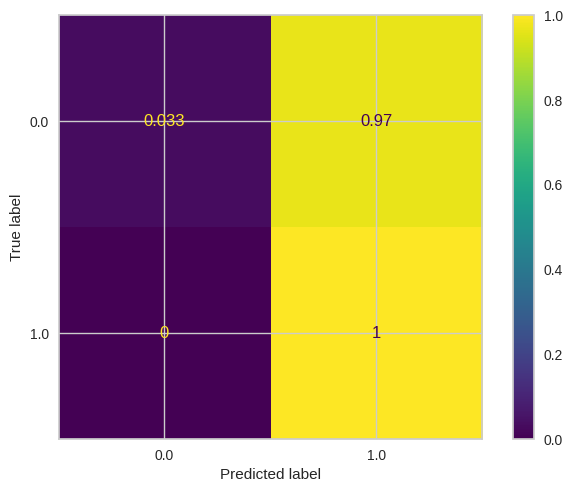

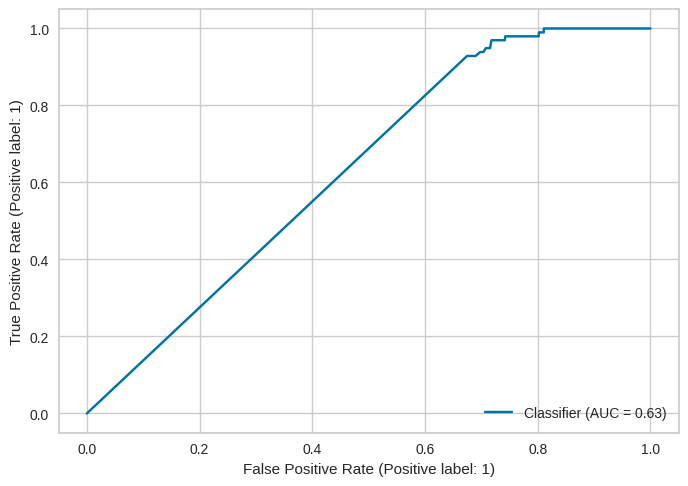

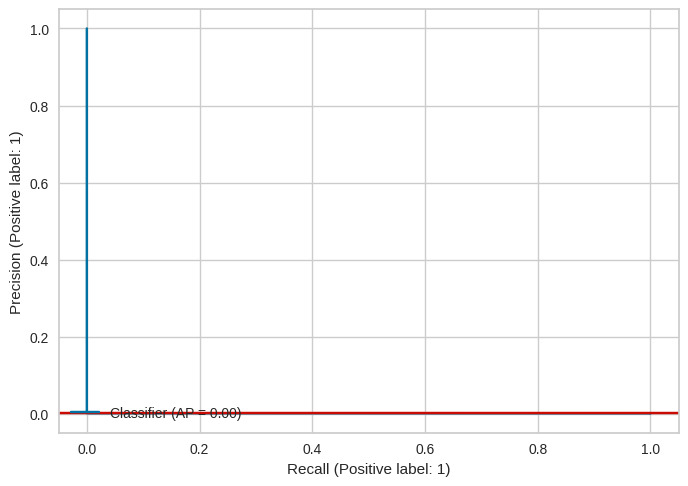

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.03      1.00      0.06      0.18      0.03     56864
        1.0       0.00      1.00      0.03      0.00      0.18      0.04        98

avg / total       1.00      0.03      1.00      0.06      0.18      0.03     56962

AUPRC: 0.4655447472044549
AP: 0.0023586811651751245


In [17]:
fw_model = FraudModel(df_concat)
fw_model.train(epochs=300)
fw_model.evaluate(df_test, confidence=0.90)

In [18]:
path = "vgan_model.pt"
torch.save(fw_model.model.state_dict(), path)

In [19]:
path = "vgan_model.pth"
torch.save(fw_model.model.state_dict(), path)

### LSTM-Based Detection

In [20]:
#split df_concat into train and test
ltsm_train, ltsm_test = train_test_split(df_concat, test_size=0.2, random_state=42)

In [21]:
def create_time_dataset(in_df, seq_size=10):
    X, y = [], []
    for i in range(len(in_df) - seq_size):
        slice = in_df[i:i+seq_size]
        X.append(slice.drop(['Class', 'Time'], axis=1).values)
        y.append(slice['Class'].values[-1])

    X = np.array(X)
    y = np.array(y)

    return torch.Tensor(X).to(device), torch.Tensor(y).to(device)

In [22]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_size = 256
        self.lstm = nn.LSTM(input_size,
                            hidden_size=self.hidden_size,
                            num_layers=5,
                            bidirectional=True,
                            batch_first=True)
        self.linear = nn.Sequential(
            nn.Linear(self.hidden_size * 2, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x, hx = self.lstm(x)
        out = torch.cat((hx[0][-2, :, :], hx[0][-1, :, :]), dim=1)
        return torch.flatten(self.linear(out))

In [23]:
class LSTMFraudModel:
    def __init__(self, train_df):
        self.lr = 0.0001
        self.batch_size = 128
        X_train, y_train = create_time_dataset(train_df)
        self.dataset = TensorDataset(X_train, y_train)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)
        self.model = LSTMModel(input_size=X_train.shape[2]).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = nn.BCELoss()

    def train(self, epochs=100):
        for epoch in range(epochs):
            epoch_loss = 0
            for _, (x, y) in enumerate(tqdm(self.dataloader)):
                x,y = x.to(device), y.to(device)
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() / len(x)
            print("[Epoch %d/%d] loss: %f" % (epoch+1, epochs, np.mean(epoch_loss)))

    def predict(self, x):
        with torch.no_grad():
            pred = self.model(x)
            return pred.cpu().numpy()

    def evaluate(self, test_df, confidence=0.50):
        input, y_true = create_time_dataset(test_df)
        dataloader = DataLoader(TensorDataset(input, y_true), self.batch_size, shuffle=False)
        preds = np.array([])
        for (inp, _) in dataloader:
            pred = self.predict(inp)
            preds = np.concatenate((preds, pred), axis=None)
        labels = np.zeros_like(preds)
        labels[preds >= confidence] = 1.0
        common_metrics(y_true.cpu().numpy(), labels, preds)

In [24]:
lstm = LSTMFraudModel(ltsm_train)

In [25]:
lstm.train(epochs=300)

100%|██████████| 2846/2846 [01:03<00:00, 44.69it/s]


[Epoch 1/300] loss: 0.499696


100%|██████████| 2846/2846 [01:02<00:00, 45.27it/s]


[Epoch 2/300] loss: 0.078206


100%|██████████| 2846/2846 [01:02<00:00, 45.40it/s]


[Epoch 3/300] loss: 0.054348


100%|██████████| 2846/2846 [01:02<00:00, 45.25it/s]


[Epoch 4/300] loss: 0.047232


100%|██████████| 2846/2846 [01:02<00:00, 45.50it/s]


[Epoch 5/300] loss: 0.041991


100%|██████████| 2846/2846 [01:03<00:00, 45.11it/s]


[Epoch 6/300] loss: 0.037635


100%|██████████| 2846/2846 [01:03<00:00, 44.79it/s]


[Epoch 7/300] loss: 0.036445


100%|██████████| 2846/2846 [01:02<00:00, 45.18it/s]


[Epoch 8/300] loss: 0.032645


100%|██████████| 2846/2846 [01:03<00:00, 45.15it/s]


[Epoch 9/300] loss: 0.029648


100%|██████████| 2846/2846 [01:02<00:00, 45.36it/s]


[Epoch 10/300] loss: 0.031888


100%|██████████| 2846/2846 [01:03<00:00, 45.09it/s]


[Epoch 11/300] loss: 0.026953


100%|██████████| 2846/2846 [01:03<00:00, 44.96it/s]


[Epoch 12/300] loss: 0.026183


100%|██████████| 2846/2846 [01:02<00:00, 45.30it/s]


[Epoch 13/300] loss: 0.025966


100%|██████████| 2846/2846 [01:03<00:00, 44.73it/s]


[Epoch 14/300] loss: 0.023758


100%|██████████| 2846/2846 [01:03<00:00, 44.87it/s]


[Epoch 15/300] loss: 0.020989


100%|██████████| 2846/2846 [01:02<00:00, 45.37it/s]


[Epoch 16/300] loss: 0.019925


100%|██████████| 2846/2846 [01:02<00:00, 45.47it/s]


[Epoch 17/300] loss: 0.018013


100%|██████████| 2846/2846 [01:02<00:00, 45.32it/s]


[Epoch 18/300] loss: 0.017240


100%|██████████| 2846/2846 [01:02<00:00, 45.23it/s]


[Epoch 19/300] loss: 0.015040


100%|██████████| 2846/2846 [01:04<00:00, 43.95it/s]


[Epoch 20/300] loss: 0.015726


100%|██████████| 2846/2846 [01:02<00:00, 45.53it/s]


[Epoch 21/300] loss: 0.013404


100%|██████████| 2846/2846 [01:02<00:00, 45.28it/s]


[Epoch 22/300] loss: 0.012509


100%|██████████| 2846/2846 [01:02<00:00, 45.77it/s]


[Epoch 23/300] loss: 0.011864


100%|██████████| 2846/2846 [01:02<00:00, 45.54it/s]


[Epoch 24/300] loss: 0.013119


100%|██████████| 2846/2846 [01:02<00:00, 45.28it/s]


[Epoch 25/300] loss: 0.012603


100%|██████████| 2846/2846 [01:02<00:00, 45.26it/s]


[Epoch 26/300] loss: 0.010099


100%|██████████| 2846/2846 [01:02<00:00, 45.25it/s]


[Epoch 27/300] loss: 0.008739


100%|██████████| 2846/2846 [01:02<00:00, 45.89it/s]


[Epoch 28/300] loss: 0.008369


100%|██████████| 2846/2846 [01:01<00:00, 45.90it/s]


[Epoch 29/300] loss: 0.007016


100%|██████████| 2846/2846 [01:02<00:00, 45.35it/s]


[Epoch 30/300] loss: 0.006585


100%|██████████| 2846/2846 [01:02<00:00, 45.40it/s]


[Epoch 31/300] loss: 0.006013


100%|██████████| 2846/2846 [01:02<00:00, 45.84it/s]


[Epoch 32/300] loss: 0.005608


100%|██████████| 2846/2846 [01:02<00:00, 45.43it/s]


[Epoch 33/300] loss: 0.004135


100%|██████████| 2846/2846 [01:02<00:00, 45.53it/s]


[Epoch 34/300] loss: 0.003610


100%|██████████| 2846/2846 [01:01<00:00, 46.10it/s]


[Epoch 35/300] loss: 0.003194


100%|██████████| 2846/2846 [01:01<00:00, 46.11it/s]


[Epoch 36/300] loss: 0.001579


100%|██████████| 2846/2846 [01:01<00:00, 46.04it/s]


[Epoch 37/300] loss: 0.005399


100%|██████████| 2846/2846 [01:01<00:00, 45.91it/s]


[Epoch 38/300] loss: 0.005028


100%|██████████| 2846/2846 [01:02<00:00, 45.50it/s]


[Epoch 39/300] loss: 0.004958


100%|██████████| 2846/2846 [01:01<00:00, 46.08it/s]


[Epoch 40/300] loss: 0.002091


100%|██████████| 2846/2846 [01:01<00:00, 45.96it/s]


[Epoch 41/300] loss: 0.010225


100%|██████████| 2846/2846 [01:02<00:00, 45.20it/s]


[Epoch 42/300] loss: 0.005209


100%|██████████| 2846/2846 [01:02<00:00, 45.45it/s]


[Epoch 43/300] loss: 0.002497


100%|██████████| 2846/2846 [01:02<00:00, 45.87it/s]


[Epoch 44/300] loss: 0.003631


100%|██████████| 2846/2846 [01:02<00:00, 45.86it/s]


[Epoch 45/300] loss: 0.003388


100%|██████████| 2846/2846 [01:01<00:00, 46.12it/s]


[Epoch 46/300] loss: 0.002059


100%|██████████| 2846/2846 [01:01<00:00, 46.05it/s]


[Epoch 47/300] loss: 0.001681


100%|██████████| 2846/2846 [01:01<00:00, 46.09it/s]


[Epoch 48/300] loss: 0.002197


100%|██████████| 2846/2846 [01:02<00:00, 45.88it/s]


[Epoch 49/300] loss: 0.001550


100%|██████████| 2846/2846 [01:03<00:00, 45.15it/s]


[Epoch 50/300] loss: 0.002862


100%|██████████| 2846/2846 [01:02<00:00, 45.86it/s]


[Epoch 51/300] loss: 0.001004


100%|██████████| 2846/2846 [01:01<00:00, 46.02it/s]


[Epoch 52/300] loss: 0.001406


100%|██████████| 2846/2846 [01:02<00:00, 45.29it/s]


[Epoch 53/300] loss: 0.003047


100%|██████████| 2846/2846 [01:02<00:00, 45.22it/s]


[Epoch 54/300] loss: 0.002554


100%|██████████| 2846/2846 [01:02<00:00, 45.73it/s]


[Epoch 55/300] loss: 0.000498


100%|██████████| 2846/2846 [01:01<00:00, 46.12it/s]


[Epoch 56/300] loss: 0.001831


100%|██████████| 2846/2846 [01:01<00:00, 46.13it/s]


[Epoch 57/300] loss: 0.001432


100%|██████████| 2846/2846 [01:01<00:00, 46.20it/s]


[Epoch 58/300] loss: 0.001930


100%|██████████| 2846/2846 [01:01<00:00, 46.10it/s]


[Epoch 59/300] loss: 0.002070


100%|██████████| 2846/2846 [01:01<00:00, 46.07it/s]


[Epoch 60/300] loss: 0.000232


100%|██████████| 2846/2846 [01:01<00:00, 46.08it/s]


[Epoch 61/300] loss: 0.001341


100%|██████████| 2846/2846 [01:01<00:00, 46.14it/s]


[Epoch 62/300] loss: 0.007225


100%|██████████| 2846/2846 [01:02<00:00, 45.75it/s]


[Epoch 63/300] loss: 0.002284


100%|██████████| 2846/2846 [01:01<00:00, 46.11it/s]


[Epoch 64/300] loss: 0.000015


100%|██████████| 2846/2846 [01:01<00:00, 46.10it/s]


[Epoch 65/300] loss: 0.000001


100%|██████████| 2846/2846 [01:01<00:00, 46.12it/s]


[Epoch 66/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.18it/s]


[Epoch 67/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.16it/s]


[Epoch 68/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.12it/s]


[Epoch 69/300] loss: 0.006105


100%|██████████| 2846/2846 [01:01<00:00, 46.10it/s]


[Epoch 70/300] loss: 0.003354


100%|██████████| 2846/2846 [01:01<00:00, 46.05it/s]


[Epoch 71/300] loss: 0.000765


100%|██████████| 2846/2846 [01:01<00:00, 46.08it/s]


[Epoch 72/300] loss: 0.000030


100%|██████████| 2846/2846 [01:01<00:00, 46.15it/s]


[Epoch 73/300] loss: 0.000001


100%|██████████| 2846/2846 [01:01<00:00, 46.14it/s]


[Epoch 74/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.11it/s]


[Epoch 75/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.08it/s]


[Epoch 76/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.14it/s]


[Epoch 77/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.18it/s]


[Epoch 78/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.14it/s]


[Epoch 79/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.08it/s]


[Epoch 80/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.08it/s]


[Epoch 81/300] loss: 0.001296


100%|██████████| 2846/2846 [01:01<00:00, 46.07it/s]


[Epoch 82/300] loss: 0.000945


100%|██████████| 2846/2846 [01:01<00:00, 46.14it/s]


[Epoch 83/300] loss: 0.018443


100%|██████████| 2846/2846 [01:01<00:00, 46.01it/s]


[Epoch 84/300] loss: 0.022836


100%|██████████| 2846/2846 [01:01<00:00, 45.93it/s]


[Epoch 85/300] loss: 0.000083


100%|██████████| 2846/2846 [01:01<00:00, 46.16it/s]


[Epoch 86/300] loss: 0.000001


100%|██████████| 2846/2846 [01:01<00:00, 46.08it/s]


[Epoch 87/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.04it/s]


[Epoch 88/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.09it/s]


[Epoch 89/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.10it/s]


[Epoch 90/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.06it/s]


[Epoch 91/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.08it/s]


[Epoch 92/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.04it/s]


[Epoch 93/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 45.93it/s]


[Epoch 94/300] loss: 0.003393


100%|██████████| 2846/2846 [01:01<00:00, 46.07it/s]


[Epoch 95/300] loss: 0.001014


100%|██████████| 2846/2846 [01:01<00:00, 46.06it/s]


[Epoch 96/300] loss: 0.000849


100%|██████████| 2846/2846 [01:01<00:00, 46.13it/s]


[Epoch 97/300] loss: 0.000004


100%|██████████| 2846/2846 [01:01<00:00, 46.10it/s]


[Epoch 98/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.03it/s]


[Epoch 99/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.08it/s]


[Epoch 100/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.13it/s]


[Epoch 101/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.20it/s]


[Epoch 102/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.09it/s]


[Epoch 103/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.05it/s]


[Epoch 104/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.06it/s]


[Epoch 105/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.10it/s]


[Epoch 106/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.17it/s]


[Epoch 107/300] loss: 0.002020


100%|██████████| 2846/2846 [01:01<00:00, 46.11it/s]


[Epoch 108/300] loss: 0.000466


100%|██████████| 2846/2846 [01:01<00:00, 46.11it/s]


[Epoch 109/300] loss: 0.001991


100%|██████████| 2846/2846 [01:01<00:00, 46.04it/s]


[Epoch 110/300] loss: 0.000202


100%|██████████| 2846/2846 [01:01<00:00, 46.10it/s]


[Epoch 111/300] loss: 0.000002


100%|██████████| 2846/2846 [01:01<00:00, 46.13it/s]


[Epoch 112/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.10it/s]


[Epoch 113/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.12it/s]


[Epoch 114/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.09it/s]


[Epoch 115/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.08it/s]


[Epoch 116/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.08it/s]


[Epoch 117/300] loss: 0.000000


100%|██████████| 2846/2846 [01:03<00:00, 45.04it/s]


[Epoch 118/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.06it/s]


[Epoch 119/300] loss: 0.000000


100%|██████████| 2846/2846 [01:02<00:00, 45.73it/s]


[Epoch 120/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.13it/s]


[Epoch 121/300] loss: 0.001050


100%|██████████| 2846/2846 [01:01<00:00, 46.03it/s]


[Epoch 122/300] loss: 0.013099


100%|██████████| 2846/2846 [01:01<00:00, 46.08it/s]


[Epoch 123/300] loss: 0.000822


100%|██████████| 2846/2846 [01:02<00:00, 45.69it/s]


[Epoch 124/300] loss: 0.003162


100%|██████████| 2846/2846 [01:01<00:00, 45.95it/s]


[Epoch 125/300] loss: 0.000440


100%|██████████| 2846/2846 [01:01<00:00, 46.10it/s]


[Epoch 126/300] loss: 0.000002


100%|██████████| 2846/2846 [01:01<00:00, 46.02it/s]


[Epoch 127/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.08it/s]


[Epoch 128/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.13it/s]


[Epoch 129/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.15it/s]


[Epoch 130/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.01it/s]


[Epoch 131/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.00it/s]


[Epoch 132/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.13it/s]


[Epoch 133/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.12it/s]


[Epoch 134/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.11it/s]


[Epoch 135/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.08it/s]


[Epoch 136/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.04it/s]


[Epoch 137/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.00it/s]


[Epoch 138/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.18it/s]


[Epoch 139/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.13it/s]


[Epoch 140/300] loss: 0.000649


100%|██████████| 2846/2846 [01:01<00:00, 45.98it/s]


[Epoch 141/300] loss: 0.002357


100%|██████████| 2846/2846 [01:01<00:00, 46.07it/s]


[Epoch 142/300] loss: 0.000022


100%|██████████| 2846/2846 [01:01<00:00, 45.94it/s]


[Epoch 143/300] loss: 0.006029


100%|██████████| 2846/2846 [01:02<00:00, 45.62it/s]


[Epoch 144/300] loss: 0.001278


100%|██████████| 2846/2846 [01:02<00:00, 45.84it/s]


[Epoch 145/300] loss: 0.000005


100%|██████████| 2846/2846 [01:01<00:00, 46.17it/s]


[Epoch 146/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.10it/s]


[Epoch 147/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.06it/s]


[Epoch 148/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.00it/s]


[Epoch 149/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.09it/s]


[Epoch 150/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.14it/s]


[Epoch 151/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.22it/s]


[Epoch 152/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.21it/s]


[Epoch 153/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.19it/s]


[Epoch 154/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.17it/s]


[Epoch 155/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.18it/s]


[Epoch 156/300] loss: 0.001652


100%|██████████| 2846/2846 [01:01<00:00, 46.20it/s]


[Epoch 157/300] loss: 0.000147


100%|██████████| 2846/2846 [01:01<00:00, 46.16it/s]


[Epoch 158/300] loss: 0.001102


100%|██████████| 2846/2846 [01:01<00:00, 46.15it/s]


[Epoch 159/300] loss: 0.000002


100%|██████████| 2846/2846 [01:01<00:00, 46.04it/s]


[Epoch 160/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.07it/s]


[Epoch 161/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 45.96it/s]


[Epoch 162/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.09it/s]


[Epoch 163/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 45.99it/s]


[Epoch 164/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.05it/s]


[Epoch 165/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.01it/s]


[Epoch 166/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.05it/s]


[Epoch 167/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 45.98it/s]


[Epoch 168/300] loss: 0.001888


100%|██████████| 2846/2846 [01:02<00:00, 45.74it/s]


[Epoch 169/300] loss: 0.010658


100%|██████████| 2846/2846 [01:02<00:00, 45.77it/s]


[Epoch 170/300] loss: 0.000011


100%|██████████| 2846/2846 [01:01<00:00, 46.03it/s]


[Epoch 171/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.01it/s]


[Epoch 172/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 45.95it/s]


[Epoch 173/300] loss: 0.000000


100%|██████████| 2846/2846 [01:02<00:00, 45.87it/s]


[Epoch 174/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 45.97it/s]


[Epoch 175/300] loss: 0.000000


100%|██████████| 2846/2846 [01:02<00:00, 45.88it/s]


[Epoch 176/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 45.95it/s]


[Epoch 177/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.07it/s]


[Epoch 178/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.13it/s]


[Epoch 179/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.11it/s]


[Epoch 180/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.19it/s]


[Epoch 181/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.05it/s]


[Epoch 182/300] loss: 0.001948


100%|██████████| 2846/2846 [01:01<00:00, 45.94it/s]


[Epoch 183/300] loss: 0.001193


100%|██████████| 2846/2846 [01:01<00:00, 45.98it/s]


[Epoch 184/300] loss: 0.000522


100%|██████████| 2846/2846 [01:01<00:00, 46.06it/s]


[Epoch 185/300] loss: 0.000019


100%|██████████| 2846/2846 [01:01<00:00, 46.11it/s]


[Epoch 186/300] loss: 0.000030


100%|██████████| 2846/2846 [01:01<00:00, 46.10it/s]


[Epoch 187/300] loss: 0.004360


100%|██████████| 2846/2846 [01:01<00:00, 46.15it/s]


[Epoch 188/300] loss: 0.000153


100%|██████████| 2846/2846 [01:01<00:00, 46.08it/s]


[Epoch 189/300] loss: 0.007072


100%|██████████| 2846/2846 [01:01<00:00, 46.10it/s]


[Epoch 190/300] loss: 0.000990


100%|██████████| 2846/2846 [01:01<00:00, 46.07it/s]


[Epoch 191/300] loss: 0.000002


100%|██████████| 2846/2846 [01:01<00:00, 46.01it/s]


[Epoch 192/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.14it/s]


[Epoch 193/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.09it/s]


[Epoch 194/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.15it/s]


[Epoch 195/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.15it/s]


[Epoch 196/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.10it/s]


[Epoch 197/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.07it/s]


[Epoch 198/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.01it/s]


[Epoch 199/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.03it/s]


[Epoch 200/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.17it/s]


[Epoch 201/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.10it/s]


[Epoch 202/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.10it/s]


[Epoch 203/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.14it/s]


[Epoch 204/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.08it/s]


[Epoch 205/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.07it/s]


[Epoch 206/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.06it/s]


[Epoch 207/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.05it/s]


[Epoch 208/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.10it/s]


[Epoch 209/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.12it/s]


[Epoch 210/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.08it/s]


[Epoch 211/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.02it/s]


[Epoch 212/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.14it/s]


[Epoch 213/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.03it/s]


[Epoch 214/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.01it/s]


[Epoch 215/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.03it/s]


[Epoch 216/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.02it/s]


[Epoch 217/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.06it/s]


[Epoch 218/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.09it/s]


[Epoch 219/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.05it/s]


[Epoch 220/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.04it/s]


[Epoch 221/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 45.99it/s]


[Epoch 222/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 45.97it/s]


[Epoch 223/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 45.97it/s]


[Epoch 224/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.00it/s]


[Epoch 225/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.07it/s]


[Epoch 226/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.11it/s]


[Epoch 227/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.08it/s]


[Epoch 228/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.19it/s]


[Epoch 229/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.11it/s]


[Epoch 230/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 45.93it/s]


[Epoch 231/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.10it/s]


[Epoch 232/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.15it/s]


[Epoch 233/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.06it/s]


[Epoch 234/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.07it/s]


[Epoch 235/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.10it/s]


[Epoch 236/300] loss: 0.000000


100%|██████████| 2846/2846 [01:02<00:00, 45.77it/s]


[Epoch 237/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.23it/s]


[Epoch 238/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.23it/s]


[Epoch 239/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.33it/s]


[Epoch 240/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.16it/s]


[Epoch 241/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.29it/s]


[Epoch 242/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.20it/s]


[Epoch 243/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.22it/s]


[Epoch 244/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.18it/s]


[Epoch 245/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.18it/s]


[Epoch 246/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.28it/s]


[Epoch 247/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.26it/s]


[Epoch 248/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.22it/s]


[Epoch 249/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.12it/s]


[Epoch 250/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.24it/s]


[Epoch 251/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.23it/s]


[Epoch 252/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.29it/s]


[Epoch 253/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.28it/s]


[Epoch 254/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.18it/s]


[Epoch 255/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.22it/s]


[Epoch 256/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.15it/s]


[Epoch 257/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.32it/s]


[Epoch 258/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.19it/s]


[Epoch 259/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.23it/s]


[Epoch 260/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.20it/s]


[Epoch 261/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.27it/s]


[Epoch 262/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.25it/s]


[Epoch 263/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.11it/s]


[Epoch 264/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.25it/s]


[Epoch 265/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.22it/s]


[Epoch 266/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.23it/s]


[Epoch 267/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.16it/s]


[Epoch 268/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.33it/s]


[Epoch 269/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.16it/s]


[Epoch 270/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.18it/s]


[Epoch 271/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.12it/s]


[Epoch 272/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.23it/s]


[Epoch 273/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.28it/s]


[Epoch 274/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.21it/s]


[Epoch 275/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.18it/s]


[Epoch 276/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.06it/s]


[Epoch 277/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.16it/s]


[Epoch 278/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.08it/s]


[Epoch 279/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.32it/s]


[Epoch 280/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.21it/s]


[Epoch 281/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.24it/s]


[Epoch 282/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.12it/s]


[Epoch 283/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.14it/s]


[Epoch 284/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.26it/s]


[Epoch 285/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.19it/s]


[Epoch 286/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.25it/s]


[Epoch 287/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.14it/s]


[Epoch 288/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.16it/s]


[Epoch 289/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.09it/s]


[Epoch 290/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.16it/s]


[Epoch 291/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.15it/s]


[Epoch 292/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.19it/s]


[Epoch 293/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.19it/s]


[Epoch 294/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 45.97it/s]


[Epoch 295/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.03it/s]


[Epoch 296/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.14it/s]


[Epoch 297/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.28it/s]


[Epoch 298/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.18it/s]


[Epoch 299/300] loss: 0.000000


100%|██████████| 2846/2846 [01:01<00:00, 46.22it/s]

[Epoch 300/300] loss: 0.000000


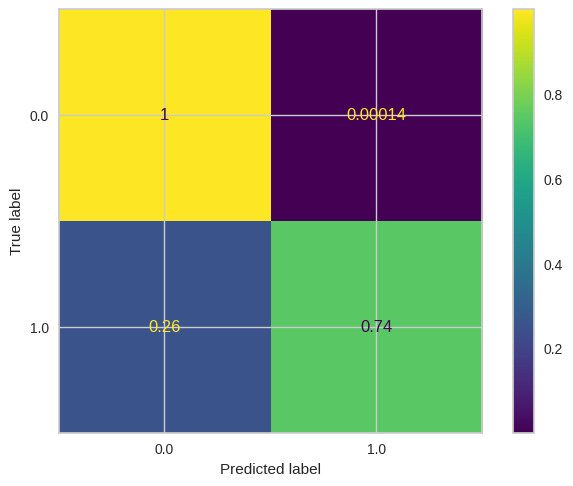

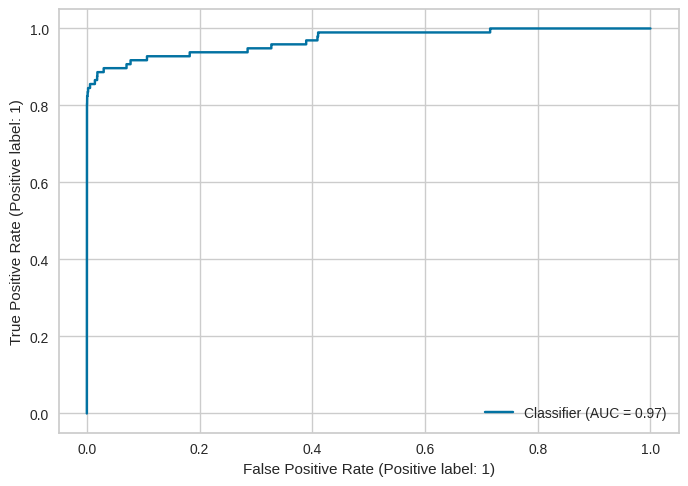

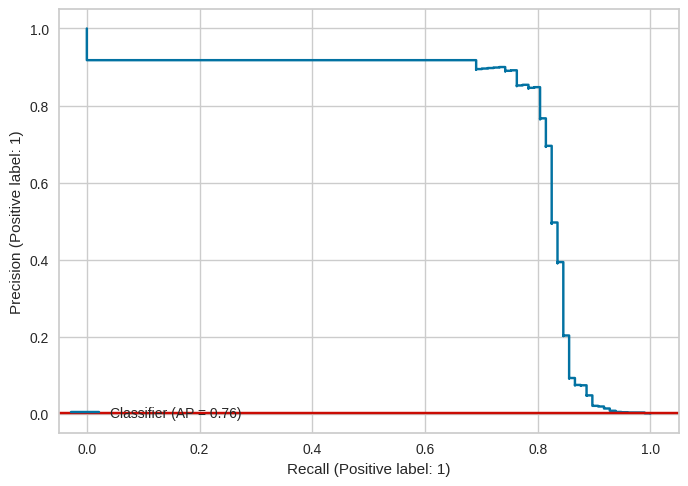

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      1.00      0.74      1.00      0.86      0.76     56855
        1.0       0.90      0.74      1.00      0.81      0.86      0.72        97

avg / total       1.00      1.00      0.74      1.00      0.86      0.76     56952

AUPRC: 0.792162242351339
AP: 0.7639449004492993


In [26]:
lstm.evaluate(df_test,confidence=0.9)

In [ ]:
path = "lstm_model.pt"
torch.save(lstm.model.state_dict(), path)


In [28]:
path = "lstm_model.pt"
torch.save(lstm.model.state_dict(), path)


### Common Regression Models

In [29]:
def common_regression_models(train_df, test_df):
    r = setup(data=train_df, target='Class', session_id=42, train_size=0.80)
    r.add_metric('apc', 'APC', average_precision_score, target='pred_proba')
    best = r.compare_models(sort='AUC')

    pred_df = predict_model(best, data=test_df.copy().drop('Class', axis=1), raw_score=True)
    l = np.argmax(pred_df[['prediction_score_0', 'prediction_score_1']].values, axis=1)
    p = pred_df[['prediction_score_0', 'prediction_score_1']].values.squeeze()
    p_bin = p[:, 1]
    p_bin[l == 0] = 1.0 - p[l == 0][:, 0]
    common_metrics(test_df['Class'].values, l, p_bin)

    return best

,Description,Value
0,Session id,42
1,Target,Class
2,Target type,Binary
3,Original data shape,"(455296, 31)"
4,Transformed data shape,"(455296, 31)"
5,Transformed train set shape,"(364236, 31)"
6,Transformed test set shape,"(91060, 31)"
7,Numeric features,30
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC,TT (Sec)
rf,Random Forest Classifier,0.9998,0.9999,0.9996,0.9999,0.9998,0.9995,0.9995,0.9999,11.4720
ada,Ada Boost Classifier,0.9996,0.9999,0.9994,0.9997,0.9996,0.9992,0.9992,1.0000,8.7310
gbc,Gradient Boosting Classifier,0.9997,0.9999,0.9995,0.9998,0.9997,0.9993,0.9993,0.9999,47.5920
et,Extra Trees Classifier,0.9998,0.9999,0.9996,0.9999,0.9998,0.9995,0.9995,0.9999,4.1120
lightgbm,Light Gradient Boosting Machine,0.9998,0.9999,0.9997,0.9999,0.9998,0.9995,0.9995,1.0000,0.6100
catboost,CatBoost Classifier,0.9997,0.9999,0.9996,0.9999,0.9997,0.9995,0.9995,1.0000,10.7430
lr,Logistic Regression,0.9980,0.9997,0.9993,0.9966,0.9980,0.9959,0.9959,0.9997,7.6120
dt,Decision Tree Classifier,0.9996,0.9996,0.9996,0.9996,0.9996,0.9991,0.9991,0.9994,1.6390
lda,Linear Discriminant Analysis,0.9973,0.9995,0.9992,0.9954,0.9973,0.9945,0.9945,0.9993,0.3850
qda,Quadratic Discriminant Analysis,0.9798,0.9993,0.9598,0.9999,0.9794,0.9596,0.9604,0.9993,0.3440


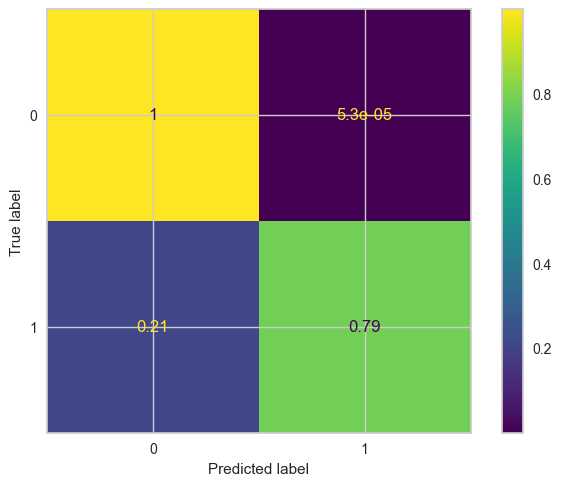

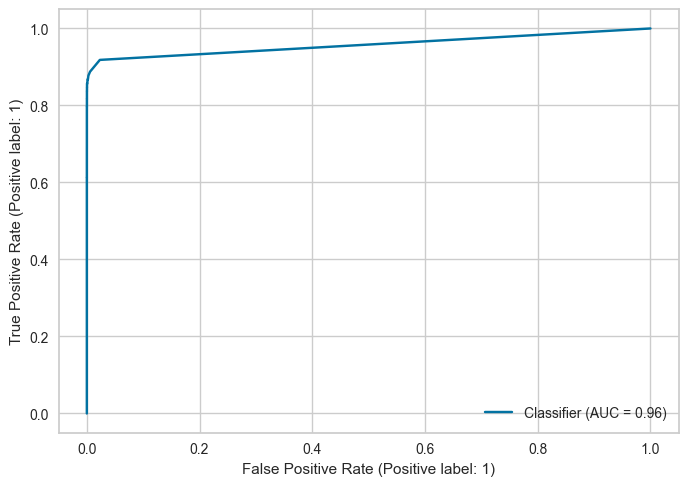

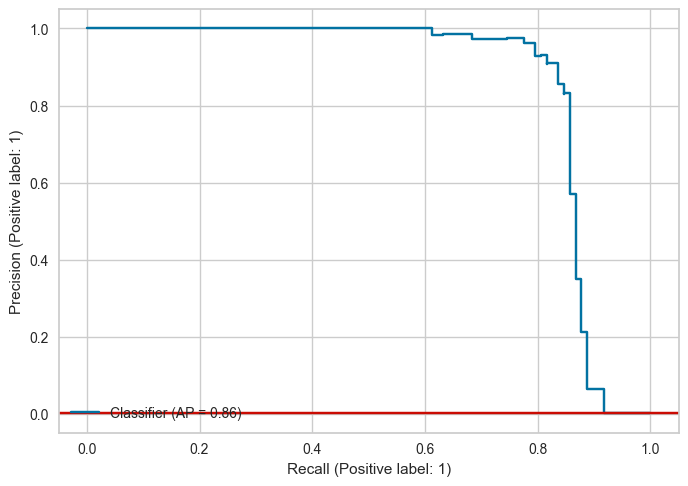

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.79      1.00      0.89      0.80     56864
          1       0.96      0.79      1.00      0.87      0.89      0.77        98

avg / total       1.00      1.00      0.79      1.00      0.89      0.80     56962

AUPRC: 0.8663406050457205
AP: 0.8600349409220891


In [ ]:
best_vgan, r_vgan = common_regression_models(df_concat, df_test)